In [ ]:
#Installs
!pip install matplotlib
!pip install nltk
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install scikit-learn
!pip install imbalanced-learn
!pip install transformers
!pip install torch
!pip install sentencepiece
!pip install xgboost

In [23]:
!pip install seaborn 

Defaulting to user installation because normal site-packages is not writeable


In [ ]:
#Requirements
import spacy  
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import math
import re  
import nltk 
from nltk.corpus import stopwords  
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.base import TransformerMixin, BaseEstimator
import torch
from transformers import CamembertTokenizer, CamembertForSequenceClassification, CamembertModel
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.utils import class_weight
from sklearn.model_selection import cross_validate
import seaborn as sns

/Users/caroline/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [29]:
#import du fichier 

file_path = os.path.join(os.getcwd(), "20220913_offers.csv")
df = pd.read_csv(file_path, sep=";", low_memory=False)

columns = ["description_entreprise","entreprise_nom"]
df = df[columns]

In [30]:
# Garder une seule ligne par entreprise_nom
df_unique = df.drop_duplicates(subset="entreprise_nom", keep="first").reset_index(drop=True)

In [4]:
df["description_entreprise"] = df["description_entreprise"].str.lower()

nltk.download('stopwords')  
stop_words = set(stopwords.words('french'))

nlp = spacy.load("fr_core_news_sm")

# Fonction de nettoyage avec lemmatisation
def clean_and_lemmatize(text):
    if isinstance(text, str):  
        text = text.lower()  # Minuscule
        text = re.sub(r'\d+', '', text)  # Suppression des chiffres
        text = re.sub(r'[^\w\s]', '', text)  # Suppression de la ponctuation
        doc = nlp(text)  # Analyse du texte avec SpaCy
        words = [token.lemma_ for token in doc if token.text not in stop_words]  # Lemmatisation + suppression stopwords
        return " ".join(words)  # Reconstituer le texte nettoyé
    return ""

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/caroline/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [31]:
file_path_2 = os.path.join(os.getcwd(), "df_augmente.csv")
df_augmente = pd.read_csv(file_path_2, sep=",", low_memory=False)
df_augmente["description_entreprise"] = df_augmente["description_entreprise"].str.lower()

In [40]:
df_augmente = df_augmente.dropna(subset=['catégories'])
df_augmente = df_augmente.dropna(subset=['description_entreprise'])
df_augmente['catégories'] = df_augmente['catégories'].astype(int)

# Vérification de la répartition des classes
print("Répartition des classes:")
print(df_augmente['catégories'].value_counts())

# Séparation des données en ensembles d'entraînement et de test (80%/20% avec stratification)
X = df_augmente["description_entreprise"]
y = df_augmente["catégories"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Répartition des classes:
catégories
2    84
1    79
3    66
4    61
5    57
Name: count, dtype: int64


In [33]:
# --- Définition du transformeur Camembert ---
class CamembertVectorizer(BaseEstimator, TransformerMixin):
    """
    Transformeur scikit-learn qui convertit un texte en un vecteur d'embedding
    à l'aide du modèle Camembert.
    """
    def __init__(self, model_name='camembert-base', device='cpu', max_length=512):
        self.model_name = model_name  # Nécessaire pour le clonage dans CV
        self.device = device
        self.max_length = max_length
        self.tokenizer = CamembertTokenizer.from_pretrained(model_name)
        self.model = CamembertModel.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        embeddings = []
        for text in X:
            # Tokenisation avec troncature et padding
            inputs = self.tokenizer(
                text,
                return_tensors='pt',
                truncation=True,
                padding='max_length',
                max_length=self.max_length
            )
            # Déplacer les tenseurs sur le device (CPU ou GPU)
            inputs = {k: v.to(self.device) for k, v in inputs.items()}
            with torch.no_grad():
                outputs = self.model(**inputs)
            # Extraction de la représentation du token [CLS] (premier token)
            emb = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
            embeddings.append(emb)
        return np.array(embeddings)

# Définir le device (utiliser "cuda" si disponible, sinon "cpu")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# --- Construction du pipeline Camembert + Régression Logistique ---
pipeline_camembert = Pipeline([
    ('camembert', CamembertVectorizer(device=device)),  # ton module perso
    ('clf', LogisticRegression(
        multi_class='multinomial',
        solver='lbfgs',
        max_iter=500,
        class_weight=class_weights_dict  # 🎯 ici le changement clé
    ))
])

1 - Régression logistique avec Camembert 

Encodage en une seule fois pour éviter que ça dure des plombes

In [41]:
vectorizer = CamembertVectorizer(device=device)

X_train_embeddings = vectorizer.transform(X_train)
X_test_embeddings = vectorizer.transform(X_test)

# Sauvegarder si besoin
np.save("X_train_embeddings.npy", X_train_embeddings)
np.save("X_test_embeddings.npy", X_test_embeddings)
np.save("y_train.npy", y_train)
np.save("y_test.npy", y_test)

In [42]:
clf = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500
)

In [43]:
from sklearn.utils import class_weight

weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: w for cls, w in zip(np.unique(y_train), weights)}

clf_weighted = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=500,
    class_weight=class_weights_dict
)


In [45]:
scoring = ['f1_macro', 'accuracy']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = cross_validate(
    clf,  # ou clf si tu testes sans poids
    X_train_embeddings,
    y_train,
    cv=cv,
    scoring=scoring
)

print("F1 Macro par fold :", results['test_f1_macro'])
print("F1 Macro moyen :", results['test_f1_macro'].mean())
print("Accuracy par fold :", results['test_accuracy'])
print("Accuracy moyenne :", results['test_accuracy'].mean())


/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_log

F1 Macro par fold : [0.48556005 0.62956259 0.56865131 0.65190572 0.53954629]
F1 Macro moyen : 0.5750451940652679
Accuracy par fold : [0.57142857 0.64285714 0.6        0.65454545 0.56363636]
Accuracy moyenne : 0.6064935064935065


In [46]:
results = cross_validate(
    clf_weighted,  # ou clf si tu testes sans poids
    X_train_embeddings,
    y_train,
    cv=cv,
    scoring=scoring
)

print("F1 Macro par fold :", results['test_f1_macro'])
print("F1 Macro moyen :", results['test_f1_macro'].mean())
print("Accuracy par fold :", results['test_accuracy'])
print("Accuracy moyenne :", results['test_accuracy'].mean())

/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_log

F1 Macro par fold : [0.46407843 0.58006843 0.55049746 0.65402496 0.5163216 ]
F1 Macro moyen : 0.552998174728131
Accuracy par fold : [0.51785714 0.58928571 0.58181818 0.65454545 0.52727273]
Accuracy moyenne : 0.5741558441558442


/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Camembert-based Classification Report (test set) :
              precision    recall  f1-score   support

           1       0.56      0.62      0.59        16
           2       0.40      0.47      0.43        17
           3       0.67      0.62      0.64        13
           4       0.47      0.58      0.52        12
           5       0.80      0.33      0.47        12

    accuracy                           0.53        70
   macro avg       0.58      0.53      0.53        70
weighted avg       0.57      0.53      0.53        70



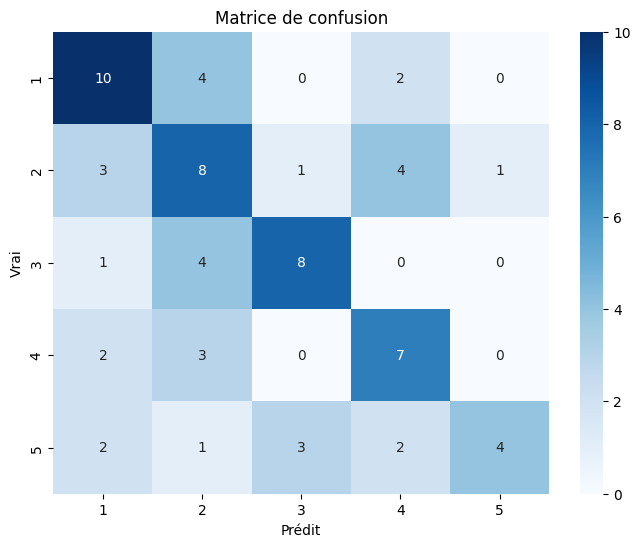

In [47]:
clf.fit(X_train_embeddings, y_train)  # ou clf

y_pred = clf.predict(X_test_embeddings)

print("Camembert-based Classification Report (test set) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()


/Users/caroline/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Camembert-based Classification Report (test set) :
              precision    recall  f1-score   support

           1       0.53      0.56      0.55        16
           2       0.50      0.47      0.48        17
           3       0.62      0.62      0.62        13
           4       0.44      0.67      0.53        12
           5       0.67      0.33      0.44        12

    accuracy                           0.53        70
   macro avg       0.55      0.53      0.52        70
weighted avg       0.55      0.53      0.52        70



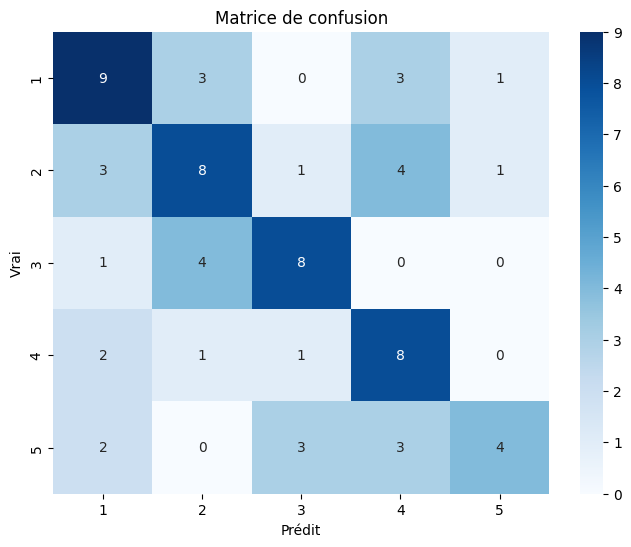

In [48]:
clf_weighted.fit(X_train_embeddings, y_train)  # ou clf

y_pred = clf_weighted.predict(X_test_embeddings)

print("Camembert-based Classification Report (test set) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()

CONCLUSION AUCUNE DIFF

Résultats de la régression logistique sans poids qui équilibre les catégories : 

Scores F1 Macro pour chaque fold : [0.48556005 0.62956259 0.56865131 0.65190572 0.53954629]
F1 Macro moyen : 0.5750451940652679

Camembert-based Classification Report:
              precision    recall  f1-score   support

           1       0.56      0.62      0.59        16
           2       0.40      0.47      0.43        17
           3       0.67      0.62      0.64        13
           4       0.47      0.58      0.52        12
           5       0.80      0.33      0.47        12

    accuracy                           0.53        70
   macro avg       0.58      0.53      0.53        70
weighted avg       0.57      0.53      0.53        70

Résultats de la régression logistique avec des poids qui équilibrent les catégories : 

F1 Macro par fold : [0.46407843 0.58006843 0.55049746 0.65402496 0.5163216 ]
F1 Macro moyen : 0.552998174728131

Camembert-based Classification Report (test set) :
              precision    recall  f1-score   support

           1       0.53      0.56      0.55        16
           2       0.50      0.47      0.48        17
           3       0.62      0.62      0.62        13
           4       0.44      0.67      0.53        12
           5       0.67      0.33      0.44        12

    accuracy                           0.53        70
   macro avg       0.55      0.53      0.52        70
weighted avg       0.55      0.53      0.52        70

In [ ]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',  # pour compenser le déséquilibre
    random_state=42
)



In [50]:
scoring = ['f1_macro', 'accuracy']
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = cross_validate(
    clf_rf,  # ou clf si tu testes sans poids
    X_train_embeddings,
    y_train,
    cv=cv,
    scoring=scoring
)

print("F1 Macro par fold :", results['test_f1_macro'])
print("F1 Macro moyen :", results['test_f1_macro'].mean())
print("Accuracy par fold :", results['test_accuracy'])
print("Accuracy moyenne :", results['test_accuracy'].mean())

F1 Macro par fold : [0.37801079 0.63943205 0.50139219 0.5585708  0.48945682]
F1 Macro moyen : 0.51337252726631
Accuracy par fold : [0.42857143 0.64285714 0.52727273 0.58181818 0.52727273]
Accuracy moyenne : 0.5415584415584416


Camembert-based Classification Report (test set) :
              precision    recall  f1-score   support

           1       0.48      0.69      0.56        16
           2       0.46      0.71      0.56        17
           3       0.70      0.54      0.61        13
           4       0.67      0.50      0.57        12
           5       1.00      0.17      0.29        12

    accuracy                           0.54        70
   macro avg       0.66      0.52      0.52        70
weighted avg       0.64      0.54      0.52        70



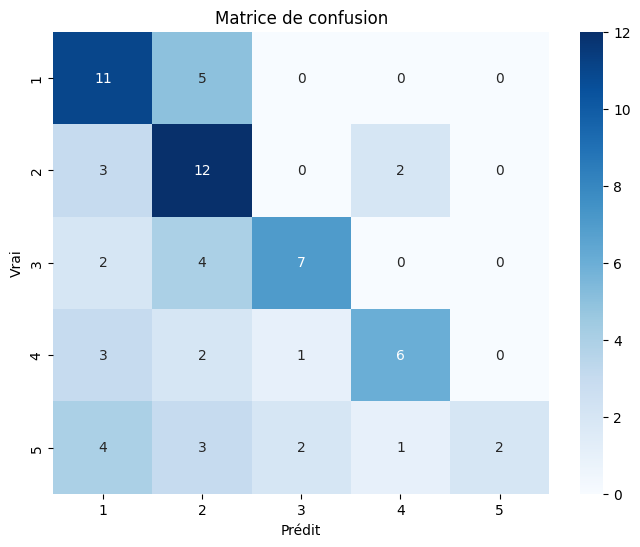

In [51]:
clf_rf.fit(X_train_embeddings, y_train)  # ou clf

y_pred = clf_rf.predict(X_test_embeddings)

print("Camembert-based Classification Report (test set) :")
print(classification_report(y_test, y_pred))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel("Prédit")
plt.ylabel("Vrai")
plt.title("Matrice de confusion")
plt.show()

C'était le random forest classifier